## Direct Optimization + A* sampling for TSP 

In [1]:
import os
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
from utils import load_model
import dirpg
from a_star_sampling import Node, Trajectory



In [3]:
class opts:
    def __init__(self,
                 max_interactions=60,
                 alpha=1.0,
                 first_improvement=False,
                 dfs_like=False,
                 not_prune=True):        
        self.max_interactions = max_interactions
        self.first_improvement = first_improvement
        self.dfs_like = dfs_like
        self.not_prune = not_prune
        self.alpha=alpha

dirpg_opts = opts()
num_cities = 8
model, _ = load_model('outputs/tsp_{}/search_candidates/DirPG_20200428T211352/'.format(num_cities), epoch = 0) # 'pretrained/tsp_100/')
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200421T162602/'.format(num_cities), epoch = 1)
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200423T155014/'.format(num_cities), epoch = 0)
model.eval()  # Put in evaluation mode to not track gradients
dirpg = dirpg.DirPG(model, dirpg_opts)

  [*] Loading model from outputs/tsp_8/search_candidates/DirPG_20200428T211352/epoch-0.pt


In [4]:
import heapq
from utils import utils_gumbel
import networkx as nx
import time

class PriorityQueue:
    def __init__(self,
                 init_state,
                 distance_mat,
                 epsilon = 1.0,
                 inference=False,
                 prune=False,
                 max_interactions=200,
                 first_improvement=False,
                 alpha=1.0,
                 dfs_like=False,
                 ):
        self.queue = []
        self.G = nx.Graph()
        
        Node.epsilon = epsilon
        init_state = init_state._replace(first_a=init_state.first_a.squeeze(0),
                                         prev_a=init_state.prev_a.squeeze(0),
                                         visited_=init_state.visited_.squeeze(0),
                                         lengths=init_state.lengths.squeeze(0),
                                         cur_coord=init_state.cur_coord.squeeze(0),
                                         ids=init_state.ids.squeeze(0),
                                         i=init_state.i.squeeze(0))

        special_action = init_state.prev_a.item()
        not_visited = [i for i in range(init_state.loc.size(1)) if i != special_action]
        self.first_coord = init_state.loc[init_state.ids, special_action]
        Node.alpha = alpha
        self.root_node = Node(id=init_state.ids,
                         first_a=init_state.first_a.item(),
                         next_actions=not_visited, # torch.tensor(not_visited),  # number of cities
                         not_visited=not_visited,
                         prefix=[special_action],
                         dist=distance_mat,
                         lengths=0.0,
                         cur_coord=self.first_coord,
                         max_gumbel=utils_gumbel.sample_gumbel(0),
                         t_opt=True)
        self.G.add_node(self.root_node)
        
        
        heapq.heappush(self.queue, self.root_node)
        self.current_node = self.root_node
        self.id = init_state.ids.item()

        self.trajectories_list = []
        self.t_opt = None
        self.t_direct = None

        self.prune_count = 0

        self.orig_dist = distance_mat
        self.start_search_direct = False
        self.first_improvement = first_improvement
        self.start_time = float('Inf')
        # self.max_search_time = max_search_time
        self.num_interactions = 0
        self.max_interactions = max_interactions
        self.dfs_like = dfs_like
        self.inference = inference
        self.prune = prune
    
        self.lower_bound = -float('Inf')
        
        #######  plotting  #######
        #priority-queue:
        self.labels = {self.root_node : 'root'}
        self.nodes_opt = []
        self.other_nodes = []
        self.ids = 1
        self.direct_node = None
        
        #prefix:
        

    def pop(self):

        if not self.queue:
            print('the queue is empty')
            return 'break'

        parent = heapq.heappop(self.queue)
        self.current_node = parent

        if self.num_interactions >= self.max_interactions:
            print('interactions budget is over')
            return 'break'

        if self.prune and self.lower_bound > parent.upper_bound:
            self.prune_count += 1
            return self.pop()

        # Start the search time count
        if not parent.t_opt and not self.start_search_direct:
            self.start_time = time.time()
            self.start_search_direct = True

        if parent.done:
            return self.set_trajectory(parent)

        return parent

    def set_trajectory(self, node):

        t = Trajectory(actions=node.prefix,
                       gumbel=node.max_gumbel,
                       length=node.lengths - (self.first_coord - node.cur_coord).norm(p=2, dim=-1),
                       objective=node.objective)

        self.trajectories_list.append(t)

        if node.t_opt:
            self.t_opt = t
            self.t_direct = t
            self.direct_node = node
            self.lower_bound = t.objective
            if self.inference:                
                return 'break'
        else:
            if t.objective > self.t_direct.objective:
                # if len(self.trajectories_list) > 2:
                #    print('here: ', len(self.trajectories_list))
                self.t_direct = t
                self.lower_bound = t.objective
                self.direct_node = node
                if self.first_improvement:
                    #print('*****  priority(direct) > priority(opt)   *****')
                    print('first improvement')
                    return 'break'

        if self.queue:
            return self.pop()
        else:
            # print('break')
            print('5')
            return 'break'

    def expand(self, state, logprobs):

        self.num_interactions += 1
        special_action = state.prev_a.item()
        s = time.time()
        not_visited = [i for i in self.current_node.not_visited if i != special_action]
        cur_coord = state.loc[self.current_node.id, special_action]
        length = -(cur_coord - self.current_node.cur_coord).norm(p=2, dim=-1)

        updated_prefix = self.current_node.prefix + [special_action]

        dist = np.delete(np.delete(self.orig_dist, updated_prefix[1:], 0), updated_prefix[1:], 1)
        special_child = Node(
            id=self.current_node.id,
            first_a=self.current_node.first_a,
            not_visited=not_visited,
            prefix=updated_prefix,
            lengths=self.current_node.lengths + length,
            cur_coord=cur_coord,
            done=len(not_visited) == 0,
            logprob_so_far=self.current_node.logprob_so_far + logprobs[special_action],
            max_gumbel=self.current_node.max_gumbel,
            next_actions=not_visited,
            depth=self.current_node.depth + 1,
            dist=dist,
            t_opt=self.current_node.t_opt,
            dfs_like=self.dfs_like)
        
        if special_child.t_opt:
            self.nodes_opt.append(special_child)
        else:
            self.other_nodes.append(special_child)
            
        self.G.add_edge(self.current_node, special_child)
        self.labels[special_child] = str(self.ids)
        self.ids+=1
        if self.prune and special_child.upper_bound < self.lower_bound:
            self.prune_count += 1

        else:
            heapq.heappush(self.queue, special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        m = time.time()
        other_actions = [i for i in self.current_node.next_actions if i != special_action]

        assert len(other_actions) == len(self.current_node.next_actions) - 1
        other_children = None
        if other_actions and not self.inference:
            other_max_location = utils_gumbel.logsumexp(logprobs[other_actions])
            other_max_gumbel = utils_gumbel.sample_truncated_gumbel(self.current_node.logprob_so_far + other_max_location,
                                                                    self.current_node.max_gumbel).item()
            other_children = Node(
                id=self.current_node.id,
                first_a=self.current_node.first_a,
                not_visited=self.current_node.not_visited,
                prefix=self.current_node.prefix,
                lengths=self.current_node.lengths,
                cur_coord=self.current_node.cur_coord,
                done=self.current_node.done,
                logprob_so_far=self.current_node.logprob_so_far,
                max_gumbel=other_max_gumbel,
                next_actions=other_actions,
                depth=self.current_node.depth + 1,
                dist=self.current_node.dist,
                t_opt=False,
                dfs_like=False)
            
            self.other_nodes.append(other_children)
            
            self.G.add_edge(self.current_node, other_children)
            self.labels[other_children] = str(self.ids)
            self.ids+=1
            if self.prune and other_children.upper_bound < self.lower_bound:
                self.prune_count += 1
            else:
                heapq.heappush(self.queue, other_children)

        f = time.time()
        sp = m - s
        oth = f - m
        return special_child, other_children



In [5]:
def encode(x, dirpg):
    embeddings = dirpg.encoder(x, only_encoder=True)
    state = dirpg.encoder.problem.make_state(x)
    fixed = dirpg.encoder.precompute(embeddings)
    return state, fixed


x = torch.rand(1, 20, 2)

def init_queue(x, dirpg, epsilon=1.0, alpha=1.0, start_from = 0):
    state, fixed = encode(x, dirpg)
    _, state = dirpg.forward_and_update(state, fixed, first_action=start_from)
    return PriorityQueue(init_state=state[torch.tensor(0)],
                                            distance_mat=state.dist[0],
                                            epsilon = epsilon,
                                            alpha=alpha,
                                            inference=False,
                                            max_interactions=dirpg.max_interactions,
                                            first_improvement=dirpg.first_improvement,
                                            dfs_like=dirpg.dfs_like,
                                            prune=dirpg.prune), state, fixed

In [6]:
def sample(queue, fixed, state):
    
    while queue:
        parent = queue.pop()
        if parent == 'break':
            return queue

        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        queue.expand(state[torch.tensor(0)], log_p[0])
    
queue,state, fixed = init_queue(x, dirpg)
queue = sample(queue, fixed, state)
print(queue.num_interactions)

interactions budget is over
60


## Interactive tree plot

In [7]:
plt.rcParams['figure.figsize'] = [16, 6]

In [42]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
#x = torch.load('good_example_8graph')
abc = string.ascii_lowercase[:x.size(1)]

In [43]:
direct, first_direct = None, True
queue,state, fixed = init_queue(x, dirpg, epsilon=2.0, alpha=1.0)

### Press Ctrl+Entr to expand the queue

#### Left: priority queue,   Right: prefix of the current node (yellow node in the left fig)

t_opt: 
['a', 'h', 'g', 'b', 'c', 'f', 'd', 'e']
t_direct: 
['a', 'h', 'g', 'b', 'c', 'f', 'd', 'e']
special child prefix: 
['a', 'g', 'c']
depth:  5


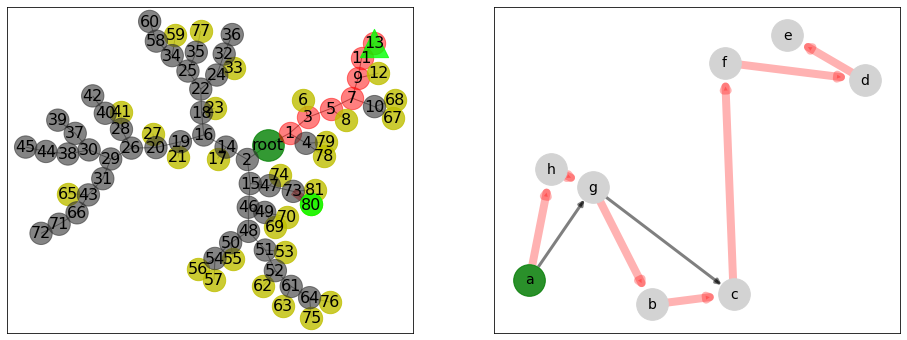

In [89]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    print('depth: ', sp.depth)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    colors = []
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=opt_nodes,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    in_queue = [i for i in queue.other_nodes if i in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=in_queue,
                           node_size = 500,
                           node_color='y',
                           alpha=0.8)
    
    out_of_queue = [i for i in queue.other_nodes if i not in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6)    
            
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

## Node size: 
##### max Gumbel
## Node color: 
##### epsilon(length + 2MST)

In [320]:
def make_circule(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    pos = nx.circular_layout(G, scale=0.5, center=(0.5,0.5))
    
    return torch.tensor([np.stack(list(pos.values()))], dtype = torch.float32)




In [321]:
def min_max_norm(x, a, b):
    min_x = np.min(x)
    max_x = np.max(x)
    return a + (((x - min_x)*(b-a))/(max_x - min_x))

def norm(x):
    return (x-np.mean(x))/np.std(x)

In [322]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [323]:
queue,state, fixed = init_queue(x, dirpg, epsilon=2.0, alpha=1.0)
update = False
direct, first_direct = None, True
parent = queue.pop()

special child prefix: 
['a', 'c', 'b', 'g', 'h', 'd']
depth:  7
alpha:  1.65


KeyError: <a_star_sampling.Node object at 0x12e316450>

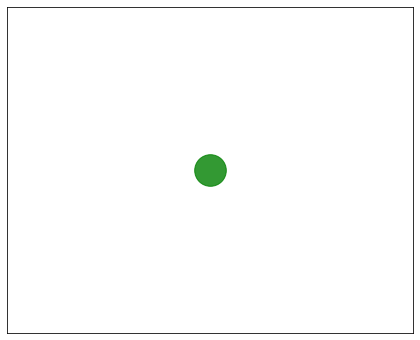

In [319]:
Node.budget = dirpg_opts.max_interactions
update = not update    

cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
if parent == 'break':
    print('END')
else:
    if update:        
        
        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
        
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    ax = plt.subplot(121)
    
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)

    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color=(0.0,1.0,0.0))
    """
    print('max_gumbel  +   eps*(- length - 2MST) = ')
    for i,j in zip([n.max_gumbel for n in queue.queue],
                  [Node.epsilon*n.get_upper_bound(2.0).item() for n in queue.queue]):
        
        print(i, ' +  ',j,  '  = ', i+j )
    """
    org_s = [n.max_gumbel for n in queue.queue]
    
    s2 = [300+4000.0*np.exp(n.max_gumbel) for n in queue.queue]
    s_mm = min_max_norm(org_s, a=np.min(org_s) ,b=np.max([5000,np.max(org_s)]))
    s_n = 300+100*norm(org_s)

    colors = [Node.epsilon*n.upper_bound.item() for n in queue.queue]
    nx.draw(queue.G, pos,
        nodelist=queue.queue,
        node_size=s2,
        node_color=colors,
        cmap=plt.cm.YlOrRd,
        alpha=0.8)
    
    out_of_queue = [i for i in queue.G if i not in queue.queue if i != queue.root_node]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6) 
    if not update:
        parent = queue.pop()
        ax.set_facecolor(color='none')
        nx.draw_networkx_nodes(queue.G, pos,ax=ax,
                               nodelist=[parent], 
                               node_size = 4000,
                               node_color='none',
                               linewidths=3.0,
                               node_shape = matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'),
                               edgecolors='b')


    
    if queue.direct_node is not None:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='*',
                               node_size = 1500,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8)
            

    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='g',min_target_margin=15)
        
        
        
    l = {i:abc[i] for i in range(x.size(1))}
    
  
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    
    

## DFS vs BFS

### DFS: Nodes that extends a prefix are colored orange 
### BFS: Nodes that search for actions other than the last node are colored blue 
### Nodes that explore different prefix are colored yellow 

In [212]:
plt.rcParams['figure.figsize'] = [16, 6]
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [231]:
queue,state, fixed = init_queue(x, dirpg, epsilon=10.0, alpha=5.0)
update = False
direct, first_direct = None, True
dfs, bfs, others = [],[],[]
last_parent = None

t_opt: 
['a', 'b', 'h', 'g', 'c', 'f', 'd', 'e']
t_direct: 
['a', 'b', 'h', 'g', 'c', 'f', 'd', 'e']
special child prefix: 
['a', 'h', 'g', 'c', 'b', 'd', 'e']
depth:  10
alpha:  5.75


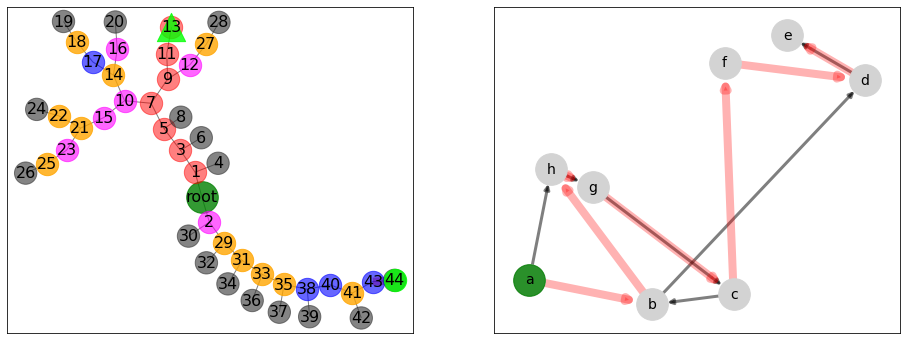

In [259]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    

    if last_parent is not None and parent not in queue.nodes_opt:

        if parent.prefix == last_parent.prefix:
            bfs.append(parent)
        elif parent.prefix[:-1] == last_parent.prefix:
            dfs.append(parent)
        else:
            others.append(parent)
        
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=queue.nodes_opt,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    others_nodes = [i for i in queue.other_nodes if i not in dfs+bfs+others]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=others_nodes,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(others_nodes))],
                           alpha=0.6) 
    
    if dfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=dfs,
                               node_size = 500,
                               node_color='orange',
                               alpha=0.8)
    if bfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=bfs,
                               node_size = 500,
                               node_color='blue',
                               alpha=0.6)  
    if others:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=others,
                               node_size = 500,
                               node_color='magenta',
                               alpha=0.6)             
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

In [103]:
a = {'a': 1}

b = {'a': 2, 'c': 3}
a.update(b)

a

{'a': 2, 'c': 3}

4